# Pytorch workshop
Kian Anvari

Github: github.com/kiananvari

Email: kiananvari@yahoo.com

Telegram: @kian_av

# Import Libraries

In [2]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Define Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Configs

In [4]:
input_size = 784 #28*28
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Dataset(MNIST)

In [5]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=preprocess, download=True)


train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)


test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=preprocess, download=True)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [11]:
examples = iter(train_loader)
samples, labels = next(examples)

print(images.shape)
print(labels.shape)


torch.Size([100, 1, 28, 28])
torch.Size([100])


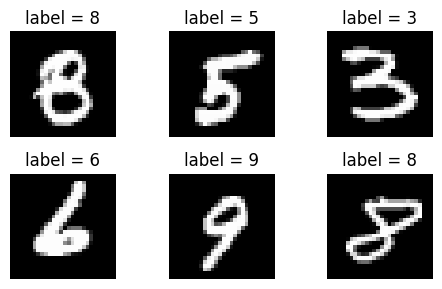

In [12]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig = plt.figure(figsize=(5, 3))

# Iterate over the first 6 samples
for i in range(6):
    # Add a subplot to the figure
    ax = fig.add_subplot(2, 3, i+1)

    # Display the image
    ax.imshow(samples[i][0], cmap="gray")

    ax.set_title(f"label = {labels[i]}")
    ax.axis("off")

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

# Define Model

In [29]:
class MLP_Net(nn.Module):
  def __init__(self, input_size, num_classes):
    super(MLP_Net, self).__init__()

    self.l1 = nn.Linear(input_size, 300)
    self.l2 = nn.Linear(300, 200)
    self.l3 = nn.Linear(200, 100)
    self.l4 = nn.Linear(100, 50)
    self.l5 = nn.Linear(50, num_classes)


    self.relu = nn.ReLU()
    self.gleu = nn.GELU()



  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.gleu(out)
    out = self.l3(out)
    out = self.relu(out)

    out = self.l4(out)
    out = self.relu(out)

    out = self.l5(out)

    return out

In [30]:
model = MLP_Net(input_size, num_classes)
model = model.to(device)

In [31]:
model

MLP_Net(
  (l1): Linear(in_features=784, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=200, bias=True)
  (l3): Linear(in_features=200, out_features=100, bias=True)
  (l4): Linear(in_features=100, out_features=50, bias=True)
  (l5): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (gleu): GELU(approximate='none')
)

# Define Criterion and Optimizer

In [32]:
criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train

In [33]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):

    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, labels) in progress_bar:

        optimizer.zero_grad()

        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        #value, index
        _, predicted = torch.max(outputs.data, 1)

        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({'Loss': train_loss / (i + 1), 'Accuracy': 100 * train_correct / train_total})

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()



    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    val_loss /= len(validation_loader)
    val_accuracy = 100 * val_correct / val_total

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/5: 100%|██████████| 480/480 [00:07<00:00, 64.12it/s, Loss=0.423, Accuracy=86.8]


Epoch 1/5, Train Loss: 0.4234, Train Accuracy: 86.82%, Val Loss: 0.2096, Val Accuracy: 93.54%


Epoch 2/5: 100%|██████████| 480/480 [00:07<00:00, 68.14it/s, Loss=0.146, Accuracy=95.6]


Epoch 2/5, Train Loss: 0.1461, Train Accuracy: 95.63%, Val Loss: 0.1239, Val Accuracy: 96.12%


Epoch 3/5: 100%|██████████| 480/480 [00:07<00:00, 63.88it/s, Loss=0.0996, Accuracy=97]


Epoch 3/5, Train Loss: 0.0996, Train Accuracy: 96.99%, Val Loss: 0.1036, Val Accuracy: 96.92%


Epoch 4/5: 100%|██████████| 480/480 [00:07<00:00, 61.98it/s, Loss=0.0726, Accuracy=97.8]


Epoch 4/5, Train Loss: 0.0726, Train Accuracy: 97.78%, Val Loss: 0.0954, Val Accuracy: 97.24%


Epoch 5/5: 100%|██████████| 480/480 [00:08<00:00, 57.64it/s, Loss=0.0548, Accuracy=98.3]


Epoch 5/5, Train Loss: 0.0548, Train Accuracy: 98.28%, Val Loss: 0.0938, Val Accuracy: 97.28%


In [21]:
import numpy as np

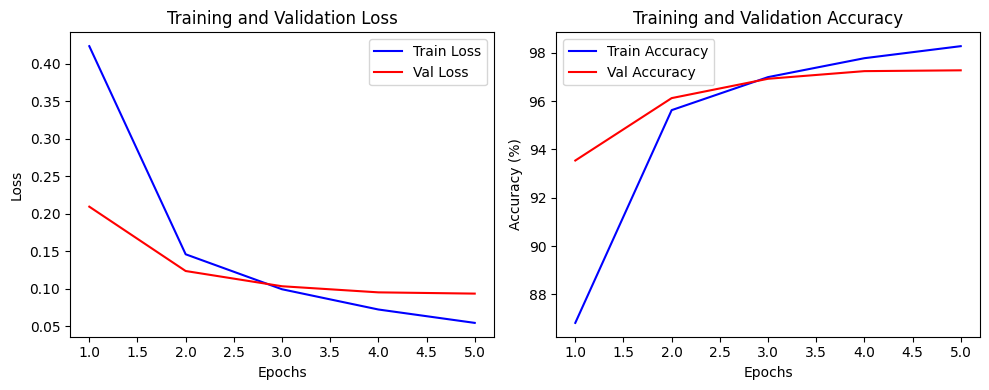

In [34]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_history, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracy_history, 'r-', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test

In [35]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0

  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    outputs = model(images)

    #value, index
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f"accuracy = {acc}")

accuracy = 97.43
